# Knapsack Problem

Algoritmus resici dany jsem implementoval v C a vyuzil Makefile pro jednoduchou konfiguraci toho jake optimalizace chceme. Tyto optimalizace se nastavuji pomoci nasledujicich direktiv:

```Makefile
# Ovlivnuje jestli se jedna o verzi hledani nejlepsi vysledku,
# nebo nam staci jen minimalni hodnota
MIN_VALUE

# Kontroluje jestli je dany vstup vubec validni (jestli celkova
# cena predmetu uspokojuje minimalni hodnotu)
VALUE_CHECK

# Vyradi predmety ktere se nevejdou ani do prazdneho batohu uz
# pri nacitani vstupu
WEIGHT_CHECK 

# Seradi predmety podle pomeru cena/vaha
ITEM_RATIO_SORT 

# Kontroluje jestli minimalni hodnota batohu je vetsi nez 0,
# jinak je vstup trivialne vyresen
ZERO_VALUE_CHECK 

# Kontroluje jestli aktualni vetev je vubec mozna dosahnout
# minimalni hodnoty batohu (B&B)
CHECK_BRANCH_VALUE 

# Vypne vypisovani do stdout, snizeni zbytecneho overheadu
DISABLE_OUTPUT 
```

Mimo techto optimalizaci je kod zkompilovan s tage -O3, tedy nejvetsi stupen optimalizace (kompilatoru). Testy jsou provadeny pomoci scriptu `test.sh`, ktery spusti 10x stejne vstupy pro program bez optimalizace (pouze direktivy `MIN_VALUE` a `DISABLE_OUTPUT`), s optimalizaci (vsechny direktivy krome `CHECK_BRANCH_VALUE`) a B&B (vsechny direktivy). Mereni casu probiha pomoci `/usr/bin/time`, ktery meri hodnoty celkovy cas behu (real), system overhead (sys) a cas samotneho algoritmu (user) v sekundach a vysledky jsou ulozeny do souboru `test_result.txt`.

Pro vstupy n>15 bylo spusteno pouze dva pruchody pro kazdou verzi programu kvuli nedostatecnemu vykonu. Stejne tak pro n>20 bylo spusteno pouze `ALL-BNB`. Tato data tedy slouzi spise pro lepsi ukazani nelinearniho rustu i pro vetsi hodnoty i v pripade pouziti metody branch and bound. Vstupy n>25 byly vynechany uplne.

Ve vsech nasledujicich grafech a textech pracujeme s hodnotou _real_. Testovaci zarizeni byl MacBook Pro (16-inch, 2019), macOS Big Sur 11.5.2 (20G95), 2.6 GHz 6-Core Intel Core i7 CPU, 16 GB 2667 MHz DDR4 RAM.

In [1]:
types = ["NR", "ZR"]
sizes = [4, 10, 15, 20, 22, 25]

# Load File
def loadFile(name):
    f = open(name, "r")
    inp = f.read().split("\n")

    real = {}
    user = {}
    sys = {}

    def getObj(t):
        if t == "real":
            return real
        if t == "user":
            return user
        if t == "sys":
            return sys

    index = ""
    for line in inp:
        if line == "":
            continue
        if "---" in line:
            index = line.split("---")[1]
            continue
        t, v = line.split()
        o = getObj(t)
        if not index in o:
            o[index] = []
        o[index].append(float(v))
    return (real, user, sys)

data = {}
for size in sizes:
    data[size] = {}
    for t in types:
        data[size][t] = loadFile("results/test_{}_result_{}.txt".format(size, t))

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.rcParams['figure.figsize'] = (20, 5)

### Prumerny cas a odchylky, NR15, 10 opakovani:

In [3]:
fig, axs = plt.subplots(1,2)
yMax = np.ceil(np.max(data[15]["NR"][0]["NO"]))
axs[0].set_ylabel('Time (s)')
axs[0].set_ylim([0, yMax])
axs[1].set_ylabel('Time (s)')
axs[1].set_ylim([0, yMax])
dfReal = pd.DataFrame(data[15]["NR"][0])
dfReal.mean().plot.bar(ax=axs[0])
dfReal.plot.box(ax=axs[1])
plt.show()

### Histogram, NR15, 10 opakovani:

In [4]:
fig, axs = plt.subplots()
fig.figsize = (10, 30)
fig.tight_layout(pad=4.0)

axs.set_xlim([0, yMax])
axs.set_xlabel('Time (s)')
dfReal.plot.hist(ax=axs, bins=200)

plt.show()

In [5]:
print(dfReal.mean())

NO         4.384
ALL        1.195
ALL-BNB    0.210
dtype: float64


Z prumernych casu (pocet spusteni = 10, soubor vstupnich dat = NR15, pocet vstupnich dat = 500) je videt ze bez optimalizace bezi *4.384s*, optimalizce jako osetrovani vstupu, serazeni predmetu atd. vypocet zrychli na *1.195s*, coz odpovida zrychleni o **~72%** a kdyz jeste odstranime vetve ktere nemohou splnit podminku dostavame se na *0.210s*, tedy zrychleni o **~95%**. Toto zrychleni je zpusobeno predevsim direktivami `VALUE_CHECK` a `WEIGHT_CHECK`, ktere vstupy vyrazne zjednodusi ci dokonce rovnou preskoci. Naivni neoptimalizovany algoritmus takove reseni prochazi a tak misty dojde k snizeni az o 2^15 vypocetnich operaci (na jeden vstup).

## Prumerny cas a odchylky, ZR15, 10 opakovani:

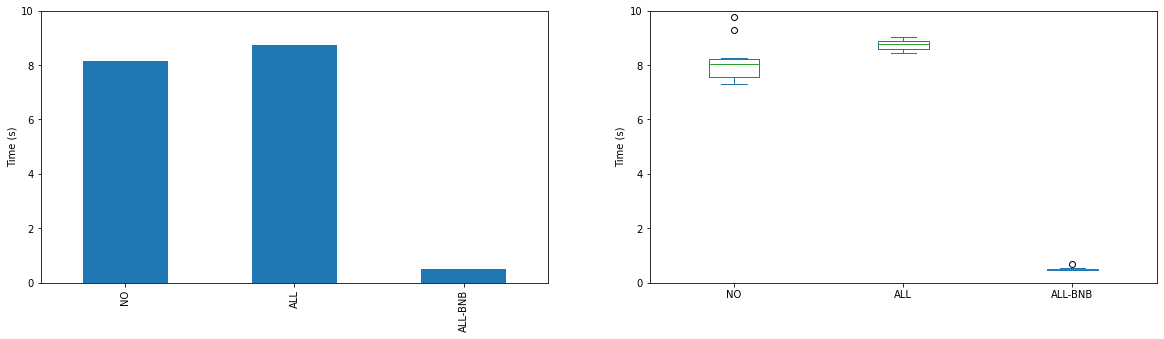

In [6]:
fig, axs = plt.subplots(1,2)
yMax = np.ceil(np.max(data[15]["ZR"][0]["ALL"]))
axs[0].set_ylabel('Time (s)')
axs[0].set_ylim([0, yMax])
axs[1].set_ylabel('Time (s)')
axs[1].set_ylim([0, yMax])
dfReal = pd.DataFrame(data[15]["ZR"][0])
dfReal.mean().plot.bar(ax=axs[0])
dfReal.plot.box(ax=axs[1])
plt.show()

## Histogram, ZR15, 10 opakovani:

In [7]:
fig, axs = plt.subplots()
fig.figsize = (10, 30)
fig.tight_layout(pad=4.0)

axs.set_xlim([0, yMax])
axs.set_xlabel('Time (s)')
dfReal.plot.hist(ax=axs, bins=200)

plt.show()

In [8]:
print(dfReal.mean())

NO         8.158
ALL        8.753
ALL-BNB    0.506
dtype: float64


Z prumernych casu (pocet spusteni = 10, soubor vstupnich dat = ZR15, pocet vstupnich dat = 500) je videt ze bez optimalizace bezi *7.737s*, optimalizce jako osetrovani vstupu, serazeni predmetu atd. vypocet zpomali na *9.045s*, coz odpovida zpomaleni o **~16%**. Naopak kdyz odstranime vetve ktere nemohou splnit podminku dostavame se na *0.576s*, tedy zrychleni o **~92%**. Na rozdil od nahodnych vstupu, kde velke mnozstvi nebylo pocitano diky direktivam `VALUE_CHECK` a `WEIGHT_CHECK` a tedy zrychlily celkovy vypocet u _nenahodnych_ kde nedochazelo k orezavani prostoru vypoctu tyto direktivy naopak pridali dalsi podminky a vetveni (co se tyce CPU optimalizace) a doslo tedy k mirnemu zpomaleni. Chytrejsi optimalizace ve forme orezavani reseni ktera uz proste nejsou resitelna zrychlila vypocet a to zhruba stejne jako v pripade nahodnych vstupu.

## Vyvoj v zavislosti na poctu predmetu v bathou

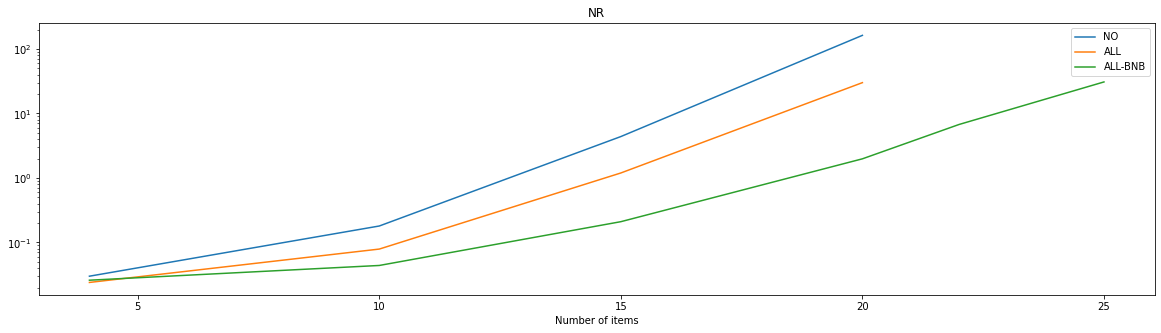

In [9]:
index = []
res = ({}, {})
for d in data:
    index.append(d)
    times = data[d]["ZR"][0]
    res[0][d] = {}
    for t in times:
        res[0][d][t] = np.mean(times[t])
    times = data[d]["NR"][0]
    res[1][d] = {}
    for t in times:
        res[1][d][t] = np.mean(times[t])
df = pd.DataFrame(res[0]).transpose()
ax = df.plot(logy=True)
ax.set_xlabel("Number of items")
ax.set_title("ZR")
plt.show()
df = pd.DataFrame(res[1]).transpose()
ax = df.plot(logy=True)
ax.set_xlabel("Number of items")
ax.set_title("NR")
plt.show()

# Zaver

Jak je videt z grafu (v logaritmickem meritku) vsechny hodnoty stoupaji nelinearne. Ackoliv tedy optimalizace snizuji delku behu, stale ma algoritmus casovou slozitost $O(n^2)$.

_Veskere data a zdrojove kody (vcetne tohoto notebooku) lze nalezt na https://gitlab.fit.cvut.cz/balardan/kom_